## 1. 라이브러리 임포트

In [16]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
# from google.colab import drive
from tensorflow.keras.applications import MobileNet
import re
import subprocess
from pathlib import Path
from typing import List, Optional
import openvino as ov
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm
import nncf
import random

## 2. 라벨링 및 Resize, Train/Test/Validation Set 지정, 데이터 로딩방식 지정

In [17]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(path):
    X = []
    Y = []

    # 각 레이블에 대한 이미지를 불러오고 전처리
    for label in ('bs', 'kcbkb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'):
        print(f"label {label}'s images Loading now'")

        label_path = os.path.join(path, label)
        if not os.path.isdir(label_path):
            print(f"cannot loading: {label_path}")
            continue

        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            img = cv2.imread(file_path)

            if img is None:
                print(f"cannot load image: {file_path}")
                continue

            # BGR에서 RGB로 변환
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 이미지 크기 조정 (224x224로 리사이즈)
            img = cv2.resize(img, (224, 224))
            X.append(img)
            Y.append(['bs', 'kcbkb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'].index(label))

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# 데이터를 불러올 디렉토리 경로를 지정
data_path = 'C:\\Users\\MyoengHo Shin\\Desktop\\kfood'

# 'train' 폴더에서 데이터를 로드
X, y = load_and_preprocess_data(os.path.join(data_path, 'train'))

# 로드된 데이터를 훈련용과 테스트용으로 분리 (테스트 데이터는 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# 'val' 폴더에서 검증 데이터를 로드
X_val, y_val = load_and_preprocess_data(os.path.join(data_path, 'val'))

label bs's images Loading now'
label kcbkb's images Loading now'
label meetsushi's images Loading now'
label pizza's images Loading now'
label pumpkin's images Loading now'
label spicypolk's images Loading now'
label sushi's images Loading now'
label tbk's images Loading now'
label zb's images Loading now'
label zzm's images Loading now'
label bs's images Loading now'
label kcbkb's images Loading now'
label meetsushi's images Loading now'
label pizza's images Loading now'
label pumpkin's images Loading now'
label spicypolk's images Loading now'
label sushi's images Loading now'
label tbk's images Loading now'
label zb's images Loading now'
label zzm's images Loading now'


# 3. 데이터 전처리

3-1. 데이터 전처리 전 샘플데이터 이미지 및 shape 확인

In [ ]:
# 전처리되기 전 라벨링 된 이미지 1장씩 확인, 이미지의 형태 확인
import matplotlib.pyplot as plt
import random

# 각 레이블별로 무작위 이미지 하나씩 띄우기
def show_random_image_per_label(X, Y, num_classes=10):
    plt.figure(figsize=(15, 6))
    for i in range(num_classes):
        # 해당 레이블의 이미지 인덱스 찾기
        indices = np.where(Y == i)[0]
        # 무작위 인덱스 선택
        idx = random.choice(indices)
        img = X[idx]

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f'Class: {i}')
        plt.axis('off')
    plt.show()

show_random_image_per_label(X, y)

# Train / Test / Val set의 Shape 출력
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Validation set shape: {X_val.shape}")

3-2. 데이터 전처리 진행

In [18]:
# 데이터 전처리
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, Sequential

# 데이터 정규화
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

# 레이블을 원-핫 인코딩으로 변환
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

# 데이터 증강 설정 (학습 데이터셋에만 적용)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(X_train)

3-3. 데이터전처리 후의 이미지, 출력형태 확인

In [ ]:
# 전처리 된 이미지 확인
import matplotlib.pyplot as plt
import numpy as np

def show_random_images(X, y, title, num_classes=10, num_images=3):
    plt.figure(figsize=(num_images * 3, 3))
    for i in range(num_images):
        idx = np.random.randint(0, len(X))
        img = X[idx]
        label = y[idx]

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Class: {np.argmax(label)}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# 훈련 데이터셋에서 무작위 이미지 표시
show_random_images(X_train, y_train, 'Random Images from Train Set')

# 테스트 데이터셋에서 무작위 이미지 표시
show_random_images(X_test, y_test, 'Random Images from Test Set')

# 검증 데이터셋에서 무작위 이미지 표시
show_random_images(X_val, y_val, 'Random Images from Validation Set')

# Train / Test / Val set의 Shape 출력
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Validation set shape: {X_val.shape}")

In [19]:
# 레이블을 원-핫 인코딩으로 변환
y_train_encoded = to_categorical(y_train, num_classes=10)  # num_classes는 실제 클래스 수에 따라 변경
y_test_encoded = to_categorical(y_test, num_classes=10)    # 테스트 데이터에 대한 원-핫 인코딩
y_val_encoded = to_categorical(y_val, num_classes=10)      # 검증 데이터에 대한 원-핫 인코딩

In [20]:
# Modeling - CNN
model = Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

In [21]:
# Model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 128)      

In [22]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# 모델 학습
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[
        ModelCheckpoint('Basic_CNN_model.h5', save_best_only=True),
        EarlyStopping(patience=20, restore_best_weights=True)
    ]
)

Epoch 1/100
198/198 [==============================] - 152s 769ms/step - loss: 1.5800 - accuracy: 0.4473 - val_loss: 1.4377 - val_accuracy: 0.5344
Epoch 2/100
198/198 [==============================] - 152s 769ms/step - loss: 1.5171 - accuracy: 0.4731 - val_loss: 1.4047 - val_accuracy: 0.5505
Epoch 3/100
198/198 [==============================] - 153s 774ms/step - loss: 1.4856 - accuracy: 0.4766 - val_loss: 1.3497 - val_accuracy: 0.5796
Epoch 4/100
198/198 [==============================] - 149s 754ms/step - loss: 1.4467 - accuracy: 0.4974 - val_loss: 1.3167 - val_accuracy: 0.6057
Epoch 5/100
198/198 [==============================] - 152s 767ms/step - loss: 1.4059 - accuracy: 0.5083 - val_loss: 1.2760 - val_accuracy: 0.5671
Epoch 6/100
198/198 [==============================] - 152s 765ms/step - loss: 1.4094 - accuracy: 0.5142 - val_loss: 1.2818 - val_accuracy: 0.6128
Epoch 7/100
198/198 [==============================] - 154s 774ms/step - loss: 1.3280 - accuracy: 0.5359 - val_loss: 1

In [26]:
# Train_Acc, Train_Loss, Test_Acc, Test_Loss Val_Acc, Val_Loss 출력
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
train_loss, train_accuracy = model.evaluate(X_train_split, y_train_encoded)
val_loss, val_accuracy = model.evaluate(X_val_split, y_val_encoded)
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Loss: {train_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Loss: {val_loss}")

InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/cond/remove_squeezable_dimensions/cond/Squeeze defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\MyoengHo Shin\AppData\Local\Temp\ipykernel_11720\3086706939.py", line 2, in <module>

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2272, in evaluate

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 4079, in run_step

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2042, in test_function

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2025, in step_function

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2013, in run_step

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1895, in test_step

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\losses.py", line 263, in call

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\utils\losses_utils.py", line 209, in squeeze_or_expand_dimensions

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\utils\losses_utils.py", line 204, in <lambda>

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\utils\losses_utils.py", line 155, in remove_squeezable_dimensions

  File "c:\Users\MyoengHo Shin\anaconda3\Lib\site-packages\keras\src\utils\losses_utils.py", line 157, in <lambda>

Detected at node cond/remove_squeezable_dimensions/cond/Squeeze defined at (most recent call last):
<stack traces unavailable>
Can not squeeze dim[2], expected a dimension of 1, got 10
	 [[{{node categorical_crossentropy/cond/remove_squeezable_dimensions/cond/Squeeze}}, {{node cond/remove_squeezable_dimensions/cond/Squeeze}}]] [Op:__inference_test_function_85931]

50/50 [==============================] - 8s 155ms/step - loss: 0.7353 - accuracy: 0.7762


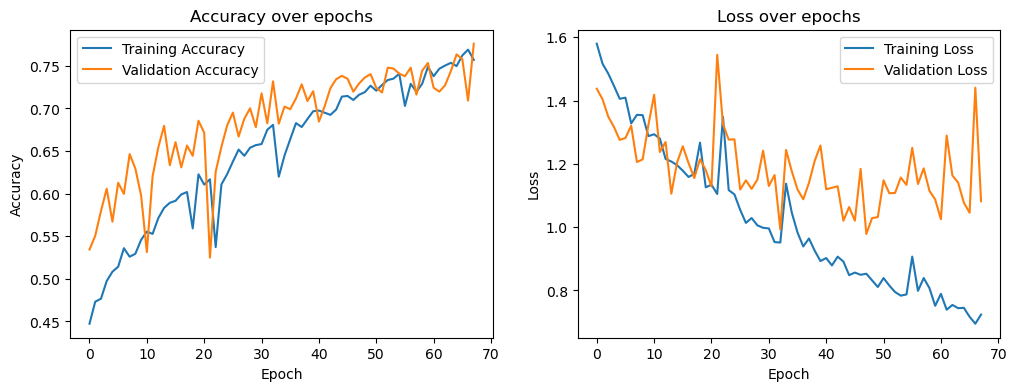

Test Accuracy: 0.7762
Test Loss: 0.7353


In [27]:
# Epoch별 정확도/손실율 표현(Train/Val/Test)

import matplotlib.pyplot as plt

def plot_history(history, test_loss, test_accuracy):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # 테스트 데이터셋의 정확도와 손실 출력
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

# 모델 평가 후 테스트 정확도와 손실을 얻습니다.
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# history와 테스트 데이터셋의 결과를 함께 전달합니다.
plot_history(history, test_loss, test_accuracy)

## 평가 및 시각화


50/50 [==============================] - 8s 153ms/step - loss: 0.7353 - accuracy: 0.7762


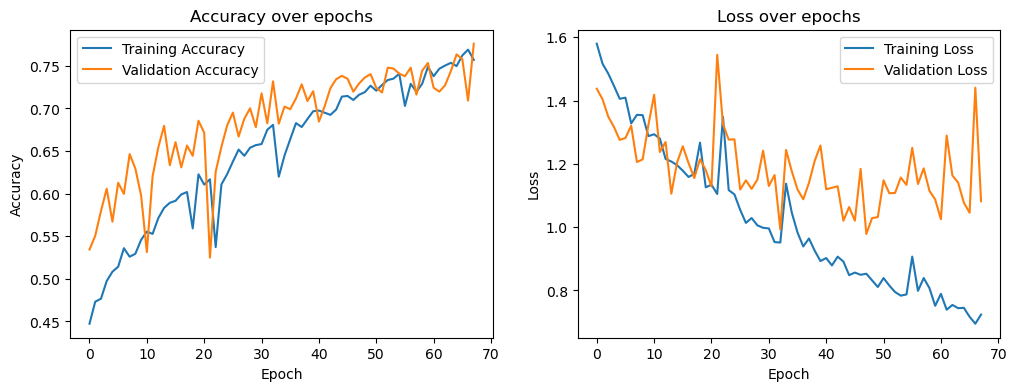

Test Accuracy: 0.7762
Test Loss: 0.7353


In [28]:
import matplotlib.pyplot as plt

def plot_history(history, test_loss, test_accuracy):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # 테스트 데이터셋의 정확도와 손실 출력
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

# 모델 평가 후 테스트 정확도와 손실을 얻습니다.
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# history와 테스트 데이터셋의 결과를 함께 전달합니다.
plot_history(history, test_loss, test_accuracy)

In [29]:
from sklearn.metrics import classification_report
import numpy as np

# 검증 데이터셋에 대한 예측
y_pred_val = model.predict(X_val)
y_pred_classes_val = np.argmax(y_pred_val, axis=1)
y_true_classes_val = np.argmax(y_val, axis=1)

# 테스트 데이터셋에 대한 예측
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_true_classes_test = np.argmax(y_test, axis=1)

def print_classification_report(y_true, y_pred, dataset_name="Dataset"):
    report = classification_report(y_true, y_pred, target_names=['bs', 'kbckb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'])
    print(f"{dataset_name} Classification Report:\n{report}")

# 검증 데이터셋에 대한 성능 평가 출력
print_classification_report(y_true_classes_val, y_pred_classes_val, "Validation")

# 테스트 데이터셋에 대한 성능 평가 출력
print_classification_report(y_true_classes_test, y_pred_classes_test, "Test")

50/50 [==============================] - 7s 143ms/step
Validation Classification Report:
              precision    recall  f1-score   support

          bs       0.71      0.51      0.59       200
       kbckb       0.79      0.76      0.77       200
   meetsushi       0.97      0.79      0.87       200
       pizza       0.72      0.83      0.77       200
     pumpkin       0.96      0.95      0.96       200
   spicypolk       0.55      0.71      0.62       200
       sushi       0.39      0.37      0.38       200
         tbk       0.69      0.68      0.69       196
          zb       0.74      0.79      0.77       195
         zzm       0.85      0.91      0.88       200

    accuracy                           0.73      1991
   macro avg       0.74      0.73      0.73      1991
weighted avg       0.74      0.73      0.73      1991

Test Classification Report:
              precision    recall  f1-score   support

          bs       0.65      0.69      0.67       171
       kbckb   

In [30]:
import os
import shutil
import time

def get_dir_size(path):
    """Calculate the total size of a directory."""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_model_size(model):
    """Calculate the size of a TensorFlow model."""
    model.save("temp_model")
    size = get_dir_size("temp_model") / (1024 * 1024)  # Convert bytes to MB
    shutil.rmtree('temp_model')  # Delete the entire directory
    return size

def predict_time(model, data):
    """Calculate the inference time for a single prediction."""
    start_time = time.time()
    model.predict(data)
    end_time = time.time()
    return end_time - start_time

In [31]:
# 모델 사이즈 및 추론 시간 계산
model_size = get_model_size(model)
print(f"Model size: {model_size:.2f} MB")

sample_inference_time = predict_time(model, np.expand_dims(X_train[0], axis=0))
print(f"Sample inference time: {sample_inference_time:.4f} seconds")

INFO:tensorflow:Assets written to: temp_model\assets


INFO:tensorflow:Assets written to: temp_model\assets


Model size: 64.65 MB
1/1 [==============================] - 0s 26ms/step
Sample inference time: 0.0651 seconds


2/2 [==============================] - 0s 79ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

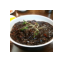

In [32]:
# Val Set 예측결과 (50장 무작위 선택, 예측성공 및 예측실패, 예측정확도 표현)
import numpy as np
import matplotlib.pyplot as plt

# 검증 데이터셋에서 무작위로 50장 선택
classes = ['bs', 'kcbkb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm']

num_samples = 50
random_indices = np.random.choice(len(X_val), num_samples, replace=False)
sample_images = X_val[random_indices]
sample_labels = y_val[random_indices]

# 예측 수행
predicted_labels = np.argmax(model.predict(sample_images), axis=1)

# 시각화
for i in range(num_samples):
    plt.subplot(5, 10, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    if sample_labels[i] == predicted_labels[i]:
        color = 'green'
    else:
        color = 'red'
    plt.title(classes[predicted_labels[i]], color=color, fontsize=8)

plt.tight_layout()
plt.show()

accuracy = np.sum(sample_labels == predicted_labels) / num_samples
print(f"Accuracy on the sampled images: {accuracy * 100:.2f}%")